/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:76: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


  0%|          | 0/7 [00:00<?, ?it/s]

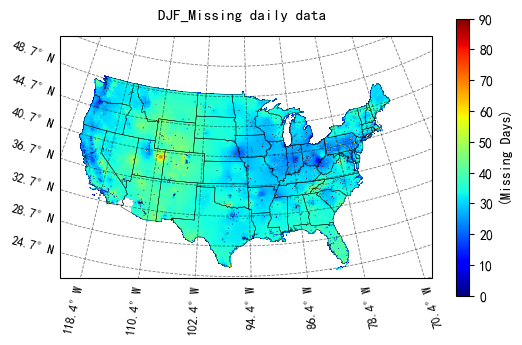

The data fusion plot for DJF is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/MissingData/DJF_Missing daily data.png


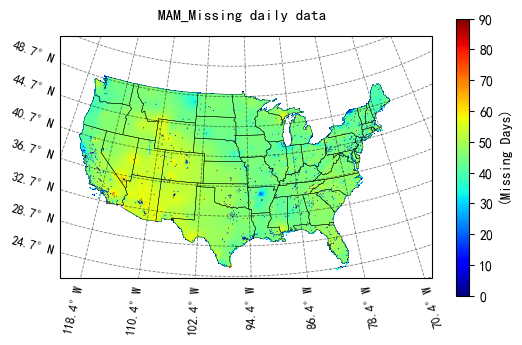

The data fusion plot for MAM is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/MissingData/MAM_Missing daily data.png


In [ ]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed
cmap_delta = cmaps.ViBlGrWhYeOrRe

def plot_us_map(
    fusion_output_file,
    model_file,
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
    points_data=None,  # 点数据
    set_zero=False  # 添加参数来控制是否将浓度设置为零
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file: the data fusion output file
    @param {string} model_file: the model file used for data fusion
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {dictionary} points_data: 点数据，包含经纬度和浓度值，default=None
    @param {bool} set_zero: 是否将浓度值设置为0，默认False
    @return None
    """
    #注意

    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if "Period" not in df_data.columns:
        print("The data fusion file does not contain the Period column!")
        return
    layout = None
    periods = ['DJF', 'MAM', 'JJA', 'SON','top-10', '98th','Annual']
    
    for period in tqdm(periods):
        dict_data = {}
        
        # 使用str.contains进行包含匹配
        df_period = df_data[df_data["Period"].str.contains(period, na=False)]
        
        # 检查是否存在 "model" 列的数据
        if "evna_ozone" not in df_period.columns or df_period["evna_ozone"].empty:
            print(f"No data found for {period} in 'model'. Skipping this period.")
            continue  # 如果没有数据，跳过该周期
        
        # 获取原始浓度数据
        grid_concentration_model = df_period["evna_ozone"].values
        
        # 确保数据大小与网格形状一致
        if grid_concentration_model.size != longitudes.size:
            print(f"Data size mismatch for {period}. Expected size {longitudes.size}, but found {grid_concentration_model.size}.")
            continue  # 如果数据大小不匹配，跳过该周期
        
        grid_concentration_model = grid_concentration_model.reshape(longitudes.shape)
        
        period_display = (
            period.replace("_daily_DF", "")
            .replace("average", "Avg.")
            .replace("Average", "Avg.")
        )
        vmax_conc = np.nanpercentile(grid_concentration_model, 99.5)
        vmin_conc = np.nanpercentile(grid_concentration_model, 0.5)
        value_range = [0, 90]
        
        # 提取特定Period的点数据
        points_data_period = points_data.get(period, None)
        if points_data_period:
            # 设定点大小为15,以及指定颜色
            points_data_period['symbol_size'] = [0.5] * len(points_data_period['lon'])
            points_data_period['edgecolor'] = 'None'
            points_data_period['cmaq'] = 'jet'
            
            # 添加点数据到dict_data
            get_multiple_data(
                dict_data,
                dataset_name=f"{period_display}_Missing daily data",
                variable_name="",
                grid_x=longitudes,
                grid_y=latitudes,
                grid_concentration=grid_concentration_model,
                points_data=points_data_period  # 传入点数据
            )
        
        fig = show_maps(
            dict_data,
            unit="Missing Days",
            cmap='jet',
            show_lonlat=True,
            projection=proj,
            is_wrf_out_data=True,
            boundary_file=boundary_json_file,
            show_original_grid=True,
            panel_layout=layout,
            show_minmax=False,
            delta_map_settings={
                "cmap": cmap_delta,
                "value_range": (0,90),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f",
            },
            title_fontsize=11,
            xy_title_fontsize=9,
            show_dependenct_colorbar=True,
            value_range=value_range,
        )
     
        if save_path is not None:
            save_file = os.path.join(save_path, f"{period_display}_Missing daily data.png")
            fig.savefig(save_file, dpi=1000)
            print(f"The data fusion plot for {period_display} is saved to {save_file}")
        dict_data = {}

if __name__ == "__main__":
    save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/MissingData"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    data_fusion_file = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronHarvard_ALL_2011_AtFIndex.csv"
    
    points_data_df = pd.read_csv('/DeepLearning/mnt/shixiansheng/data_fusion/output/missing_days_per_site_2011.csv')
    points_data = {}
    periods = ['DJF','MAM','JJA','SON','Annual','top-10','Apr-Sep','98th']
    for period in periods:
        period_data = points_data_df[points_data_df['Period'].str.contains(period, na=False)]

        #过滤掉极端的经纬度，远离美国陆地外的监测站
        period_data = period_data[(period_data['Lon'] >= -134.4) & (period_data['Lon'] <= -66.4)]
        points_data[period] = {'lon': period_data['Lon'].tolist(),
                               'lat': period_data['Lat'].tolist(),
                               'value': period_data['Conc'].tolist()}
    
    #True set_zero可以使得背景模型浓度vna置为0
    for file in [data_fusion_file]:
        plot_us_map(file, model_file, save_path, points_data=points_data, set_zero=True)
    print("Done!")
